In [6]:
from utils import *
import os
import numpy as np

Setup_environment()

from hpe_wrapper import Wrapper_2Dpose, Wrapper_3Dpose


# Define the path for the data_3d file
data_3d_path = 'data/intermedia/data_3d.npz'

# Check if the data_3d file exists
if os.path.exists(data_3d_path):
    # Load the data_3d if it exists
    loaded_data = np.load(data_3d_path)
    data_3d = loaded_data['data_3d']
else:
    # Your existing code to generate data_3d
    model_2D ='./detectron/configs/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml'
    weights_2D = './detectron/checkpoint/model_final_997cc7.pkl'
    model_3D = './VideoPose3D/checkpoint/pretrained_h36m_detectron_coco.bin'

    pose2d = Wrapper_2Dpose(model=model_2D, weights=weights_2D, ROI_thr=0.75)
    pose_3d = Wrapper_3Dpose(model_3D)

    config = load_config()
    print(config['video_object'])

    video_object = Video_wrapper(config['video_object'], resize_video_by=0.3)
    data_2d, metadata_vid = pose2d.predict_2D_poses(input_video_object=video_object)
    data_3d = pose_3d.predict_3D_poses(data_2d, metadata_vid)

    # Save the data_3d to an .npz file for future use
    np.savez(data_3d_path, data_3d=data_3d)

## Pose Optim  Loop

In [4]:
import torch
from tensor_ergonomics import RULAXXX

def run_pose_optimization(original_pose, num_steps=3):
    """
    Optimize the pose using the RULA score.
    
    Parameters:
    - original_pose: A tensor of shape (17, 3)
    
    Returns:
    - Optimized pose.
    """
    #torch.autograd.set_detect_anomaly(True)
    if not isinstance(original_pose, torch.Tensor):
        original_pose = torch.tensor(original_pose)

    original_pose = original_pose.clone().detach().requires_grad_(True)

    optimizer = torch.optim.Adam([original_pose], lr=0.1) #(1,200t, 17, 3)

    for step in range(num_steps):
        optimizer.zero_grad()

        rula_eval = RULAXXX(original_pose)
        rula_score = rula_eval.compute_scores()
        print(rula_score.grad_fn)
        ergo_sum = rula_score.sum()
        loss = ergo_sum
        
        loss.backward()
        print(original_pose.grad)
        optimizer.step()
        print(f"Step {step}: Loss: {loss.item()}, RULA Score: {rula_score.sum().item()}")
        
    return original_pose

optimized_pose = run_pose_optimization(data_3d)

p = optimized_pose.detach().numpy()
print('Original pose: ', data_3d[1,1,])
print('Optim pose: ', p[1,1,:])

Angles: torch.Size([168, 14])
--- Frame 0: ---
Frame: tensor([ 14.3200, 111.9615,  36.7538, 119.7843,  29.0617,  43.0275,   9.8064,
         23.7113,  14.8478,   1.2035,  91.7161,  35.1584,  99.9522,  98.7746],
       grad_fn=<UnbindBackward0>)
Max shoulder: tensor(36.7538, grad_fn=<MaximumBackward0>)
Max abduction: tensor(119.7843, grad_fn=<MaximumBackward0>)
Max elbow: tensor(43.0275, grad_fn=<MaximumBackward0>)
Score Upper Arm: tensor([[2.]], grad_fn=<AddBackward0>)
Score Lower Arm: tensor([1.], grad_fn=<CatBackward0>)
Current Score A: tensor([2.])
Score Neck: tensor([1.], grad_fn=<CatBackward0>)
Score Trunk: tensor([1.], grad_fn=<CatBackward0>)
Min knee: tensor(9.8064, grad_fn=<MinimumBackward0>)
Score Legs: tensor([1.], grad_fn=<CatBackward0>)
Current Score B: tensor(1.)
Clamped Curr A B score for index:  tensor([2.], requires_grad=True) tensor(1., requires_grad=True)
Index 1 and 2:  tensor([1]) tensor(0)
Current Total Score: tensor([2.])
Total Score: [tensor([2.])]
--- Frame 1: -

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# FAKE

In [1]:
#FAKEEEEEEfrom utils import *
import os
import numpy as np
from utils import Setup_environment
Setup_environment()
from hpe_wrapper import Wrapper_2Dpose, Wrapper_3Dpose
from torch.autograd import gradcheck
from FAKE import FAKE
import torch
import torch.optim as optim
import torch.nn as nn

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
data_3d_path = 'data/intermedia/data_3d.npz'
# Check if the data_3d file exists
if os.path.exists(data_3d_path):
    # Load the data_3d if it exists
    loaded_data = np.load(data_3d_path)
    data_3d = loaded_data['data_3d']
else:
    model_2D ='./detectron/configs/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml'
    weights_2D = './detectron/checkpoint/model_final_997cc7.pkl'
    model_3D = './VideoPose3D/checkpoint/pretrained_h36m_detectron_coco.bin'

    pose2d = Wrapper_2Dpose(model=model_2D, weights=weights_2D, ROI_thr=0.75)
    pose_3d = Wrapper_3Dpose(model_3D)
    config = load_config()
    print(config['video_object'])

    video_object = Video_wrapper(config['video_object'], resize_video_by=0.3)
    data_2d, metadata_vid = pose2d.predict_2D_poses(input_video_object=video_object)
    data_3d = pose_3d.predict_3D_poses(data_2d, metadata_vid)
    np.savez(data_3d_path, data_3d=data_3d)

def print_grad(named_tensor):
    tensor_name, tensor = named_tensor
    if tensor.grad is not None:
        print(f"Gradient for {tensor_name}: {tensor.grad}")
    else:
        print(f"No gradient for {tensor_name}")

def vector_difference(vector1, vector2):
    vector2 = vector2.cpu().numpy()
    vector1 = np.array(vector1)

    difference = vector1 - vector2

    return difference

def matrix_difference(matrix1, matrix2):
    if isinstance(matrix2, torch.Tensor):
        matrix2 = matrix2.cpu().numpy()
    elif not isinstance(matrix2, np.ndarray):
        matrix2 = np.array(matrix2)
    difference = matrix1 - matrix2

    # calculate the Euclidean norm (L2 norm) of the difference
    norm = np.linalg.norm(difference)

    return norm

def optimize_pose(pose_3d_initial, fake_loss, lr=0.01, num_steps=10, print_interval=1):
    # Adjust the size of small_input for gradcheck
    first_dim = torch.arange(0, 2).view(-1, 1, 1)
    second_dim = torch.arange(0, 17).view(1, -1, 1)
    third_dim = torch.randn(1, 1, 3)
    result_tensor = first_dim + second_dim + third_dim
    print(result_tensor.shape)
    print(pose_3d_initial.shape)
    # The first_dim tensor is broadcasted to match the shape (168, 7, 1)
    small_input = torch.randn_like(result_tensor, dtype=torch.double, requires_grad=True)

    # Perform gradcheck
    #gradcheck_result = gradcheck(fake_loss, small_input, eps=1e-6, atol=1e-4)
    # print("Gradcheck passed:", gradcheck_result)

    #if not gradcheck_result:
    #print("Gradcheck failed, check the implementation of FakeLoss")
    #return None    


    pose_3d = pose_3d_initial.clone().detach().requires_grad_(True)

    L1_loss = nn.L1Loss(reduction='sum')
    optimizer = optim.Adam([pose_3d], lr=lr)

    for step in range(num_steps):
        print(step, '--------------------------------')

        optimizer.zero_grad()

        # cart_loss = L1_loss(pose_3d, pose_3d_initial)
        # print('cart_loss: ', cart_loss)
        ergo_loss = fake_loss(pose_3d)
        print('ergo_loss: ', ergo_loss)
        loss = ergo_loss

        loss.backward()
        print('pose_3d.grad =', pose_3d.grad)
        print('pose_3d.requires_grad', pose_3d.requires_grad)

        optimizer.step()

        if step % print_interval == 0:
            print(f"Step {step}, Loss: {loss.item()}")

    return pose_3d.detach()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
initial_pose_3d = data_3d
if isinstance(initial_pose_3d, np.ndarray):
    initial_pose_3d = torch.from_numpy(initial_pose_3d).float()


initial_pose_3d = initial_pose_3d.to(device)
initial_pose_3d.requires_grad_(True)

fake_module = FAKE(device)
fake_module.to(device)

optimized_pose = optimize_pose(initial_pose_3d, fake_module)
difference = matrix_difference( data_3d[1,:,], optimized_pose[1,:,:])
print("Difference between the matrix:")
print(difference)
optimized_pose = optimized_pose.cpu()
optimized_pose = optimized_pose.numpy()

torch.Size([2, 17, 3])
torch.Size([168, 17, 3])
0 --------------------------------
AAAAAngles:  None
Frame: 0
Difference:  0.9999997615814209  -  1.0
Frame: 1
Difference:  0.9999998807907104  -  1.0
Frame: 2
Difference:  0.9999998807907104  -  1.0
Frame: 3
Difference:  0.9999998807907104  -  1.0
Frame: 4
Difference:  1.0  -  1.0
Frame: 5
Difference:  1.0  -  1.0
Frame: 6
Difference:  1.0  -  1.0
Frame: 7
Difference:  1.0  -  1.0
Frame: 8
Difference:  1.0  -  1.0
Frame: 9
Difference:  1.0  -  1.0
Frame: 10
Difference:  1.0  -  1.0
Frame: 11
Difference:  1.0  -  1.0
Frame: 12
Difference:  1.0  -  1.0
Frame: 13
Difference:  1.0  -  1.0
Frame: 14
Difference:  1.0  -  1.0
Frame: 15
Difference:  1.2189394235610962  -  2.0
Frame: 16
Difference:  1.774940013885498  -  2.0
Frame: 17
Difference:  1.9463390111923218  -  2.0
Frame: 18
Difference:  1.9714906215667725  -  2.0
Frame: 19
Difference:  1.991283893585205  -  2.0
Frame: 20
Difference:  1.9952470064163208  -  2.0
Frame: 21
Difference:  1.9

# Fake LOSS        

In [1]:
#FAKELOSS
from utils import *
import os
import numpy as np
Setup_environment()
from hpe_wrapper import Wrapper_2Dpose, Wrapper_3Dpose
from torch.autograd import gradcheck
from FakeLoss import FakeLoss
import torch
import torch.optim as optim
import torch.nn as nn

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
data_3d_path = 'data/intermedia/data_3d.npz'
# Check if the data_3d file exists
if os.path.exists(data_3d_path):
    # Load the data_3d if it exists
    loaded_data = np.load(data_3d_path)
    data_3d = loaded_data['data_3d']
else:
    model_2D ='./detectron/configs/COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml'
    weights_2D = './detectron/checkpoint/model_final_997cc7.pkl'
    model_3D = './VideoPose3D/checkpoint/pretrained_h36m_detectron_coco.bin'

    pose2d = Wrapper_2Dpose(model=model_2D, weights=weights_2D, ROI_thr=0.75)
    pose_3d = Wrapper_3Dpose(model_3D)
    config = load_config()
    print(config['video_object'])

    video_object = Video_wrapper(config['video_object'], resize_video_by=0.3)
    data_2d, metadata_vid = pose2d.predict_2D_poses(input_video_object=video_object)
    data_3d = pose_3d.predict_3D_poses(data_2d, metadata_vid)
    np.savez(data_3d_path, data_3d=data_3d)

def print_grad(named_tensor):
    tensor_name, tensor = named_tensor
    if tensor.grad is not None:
        print(f"Gradient for {tensor_name}: {tensor.grad}")
    else:
        print(f"No gradient for {tensor_name}")

def vector_difference(vector1, vector2):
    vector2 = vector2.cpu().numpy()
    vector1 = np.array(vector1)

    difference = vector1 - vector2

    return difference

def optimize_pose(pose_3d_initial, fake_loss, lr=0.01, num_steps=100, print_interval=10):
    # Adjust the size of small_input for gradcheck
    first_dim = torch.arange(0, 2).view(-1, 1, 1)
    second_dim = torch.arange(0, 17).view(1, -1, 1)
    third_dim = torch.randn(1, 1, 3)
    result_tensor = first_dim + second_dim + third_dim
    print(result_tensor.shape)
    print(pose_3d_initial.shape)
    # The first_dim tensor is broadcasted to match the shape (168, 7, 1)
    small_input = torch.randn_like(result_tensor, dtype=torch.double, requires_grad=True)

    # Perform gradcheck
    #gradcheck_result = gradcheck(fake_loss, small_input, eps=1e-6, atol=1e-4)
    # print("Gradcheck passed:", gradcheck_result)

    #if not gradcheck_result:
        #print("Gradcheck failed, check the implementation of FakeLoss")
        #return None    

    
    pose_3d = pose_3d_initial.clone().detach().requires_grad_(True)

    L1_loss = nn.L1Loss(reduction='sum')
    optimizer = optim.Adam([pose_3d], lr=lr)

    for step in range(num_steps):
        print(step, '--------------------------------')
     
        optimizer.zero_grad()

        # cart_loss = L1_loss(pose_3d, pose_3d_initial)
        # print('cart_loss: ', cart_loss)
        ergo_loss = fake_loss(pose_3d) 
        print('ergo_loss: ', ergo_loss)
        loss = ergo_loss
        
        loss.backward()
        print('pose_3d.grad =', pose_3d.grad)
        print('pose_3d.requires_grad', pose_3d.requires_grad)

        optimizer.step()

        if step % print_interval == 0:
            print(f"Step {step}, Loss: {loss.item()}")

    return pose_3d.detach()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
initial_pose_3d = data_3d
if isinstance(initial_pose_3d, np.ndarray):
    initial_pose_3d = torch.from_numpy(initial_pose_3d).float()


initial_pose_3d = initial_pose_3d.to(device)
initial_pose_3d.requires_grad_(True)

fake_loss_module = FakeLoss(device)  
fake_loss_module.to(device)


optimized_pose = optimize_pose(initial_pose_3d, fake_loss_module)
difference = vector_difference( data_3d[1,:2,], optimized_pose[1,:2,:])
print("Difference between the vectors:")
print(difference)
optimized_pose = optimized_pose.cpu()  
optimized_pose = optimized_pose.numpy()   

torch.Size([2, 17, 3])
torch.Size([168, 17, 3])
0 --------------------------------
AAAAAngles:  torch.Size([168, 14])
tensor_1x1 : tensor([[0.3952]], requires_grad=True)
ergo_loss:  tensor(555., grad_fn=<SumBackward0>)
pose_3d.grad = None
pose_3d.requires_grad True
Step 0, Loss: 555.0
1 --------------------------------
AAAAAngles:  torch.Size([168, 14])
tensor_1x1 : tensor([[0.2628]], requires_grad=True)
ergo_loss:  tensor(555., grad_fn=<SumBackward0>)
pose_3d.grad = None
pose_3d.requires_grad True
2 --------------------------------
AAAAAngles:  torch.Size([168, 14])
tensor_1x1 : tensor([[0.7709]], requires_grad=True)
ergo_loss:  tensor(555., grad_fn=<SumBackward0>)
pose_3d.grad = None
pose_3d.requires_grad True
3 --------------------------------
AAAAAngles:  torch.Size([168, 14])
tensor_1x1 : tensor([[0.3620]], requires_grad=True)
ergo_loss:  tensor(555., grad_fn=<SumBackward0>)
pose_3d.grad = None
pose_3d.requires_grad True
4 --------------------------------
AAAAAngles:  torch.Size([

KeyboardInterrupt: 

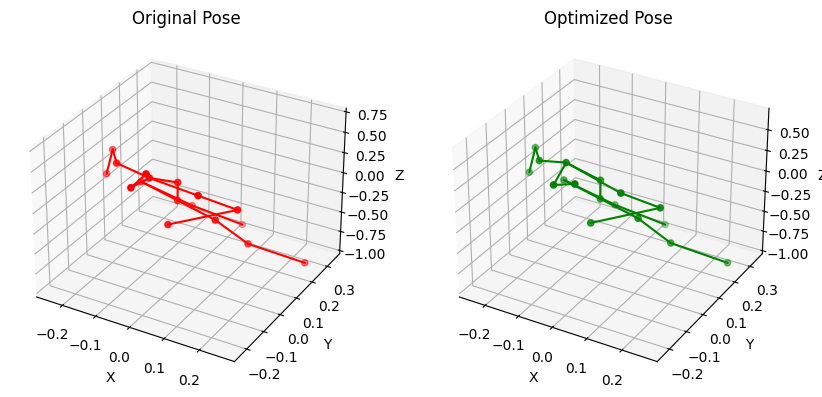

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def visualize_poses_in_video(original_pose, optimized_pose):
    # Number of frames
    num_frames = original_pose.shape[0]

    # Define pairs of keypoints to connect
    pairs = [(0, 1), (0, 4), (0, 7), (7, 8), (8, 9), (9, 10), (4, 5), (1, 2), (5, 6), (2, 3),
             (8, 11), (8, 14), (11, 12), (14, 15), (12, 13), (15, 16)]

    # Initialize plot with two subplots
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # Function to update each frame in the animation
    def update_graph(num, original_pose, optimized_pose, pairs):
        ax1.clear()
        ax2.clear()

        # Plot for original pose in red
        x, y, z = original_pose[num, :, 0], original_pose[num, :, 2], -original_pose[num, :, 1]
        ax1.scatter(x, y, z, color='red')
        for pair in pairs:
            ax1.plot([x[pair[0]], x[pair[1]]], [y[pair[0]], y[pair[1]]], [z[pair[0]], z[pair[1]]], color='red')
        ax1.set_title('Original Pose')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')

        # Plot for optimized pose in green
        x, y, z = optimized_pose[num, :, 0], optimized_pose[num, :, 2], -optimized_pose[num, :, 1]
        ax2.scatter(x, y, z, color='green')
        for pair in pairs:
            ax2.plot([x[pair[0]], x[pair[1]]], [y[pair[0]], y[pair[1]]], [z[pair[0]], z[pair[1]]], color='green')
        ax2.set_title('Optimized Pose')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')

        return fig,

    # Create animation
    ani = animation.FuncAnimation(fig, update_graph, fargs=(original_pose, optimized_pose, pairs),
                                  frames=num_frames, interval=100, blit=False)

    # Save the animation as a video
    ani.save('poses_comparison.mp4', writer='ffmpeg', fps=10)
visualize_poses_in_video(data_3d, optimized_pose)

In [16]:
optimized_pose.shape

(168, 17, 3)

In [7]:
data_3d[1,:16,:]

array([[ 9.01375824e-05, -4.42465280e-05, -2.42432452e-06],
       [-1.20477363e-01, -1.70496050e-02,  8.98614749e-02],
       [-1.77182004e-01,  4.43145454e-01,  1.79536864e-01],
       [-6.18518628e-02,  8.54370594e-01,  3.59681517e-01],
       [ 1.20479107e-01,  1.70528982e-02, -8.98441151e-02],
       [ 1.16865806e-01,  4.56653535e-01,  7.60139450e-02],
       [ 1.85573027e-01,  8.75679076e-01,  2.82008171e-01],
       [ 1.83085315e-02, -2.60643959e-01, -3.74350511e-02],
       [-3.83962169e-02, -5.10879576e-01, -1.30230382e-01],
       [-1.26177400e-01, -5.61319470e-01, -2.27296904e-01],
       [-1.27039254e-01, -6.84304237e-01, -2.18090028e-01],
       [ 1.01962164e-01, -4.34318870e-01, -1.87272042e-01],
       [ 2.16201305e-01, -1.66854590e-01, -1.69129059e-01],
       [ 2.03897968e-01,  8.87209624e-02, -2.05685571e-01],
       [-1.39150336e-01, -4.63823557e-01, -1.03630200e-02],
       [-2.02259898e-01, -2.39272729e-01,  2.18692213e-01]], dtype=float32)

In [17]:
import plotly.graph_objects as go
import webbrowser
import time

def visualize_frame(frame):
    # Extract x, y, z coordinates of keypoints
    x = frame[:, 0]
    y = frame[:, 2]
    z = - frame[:, 1]

    # Create a scatter plot for the keypoints
    scatter = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(size=5, color='red')
    )

    # Define pairs of keypoints to connect with green lines
    pairs = [(0,1), (0,4), (0,7), (7,8), (8,9), (9,10), (4,5), (1,2), (5,6), (2,3),
             (8,11), (8,14), (11,12), (14,15), (12,13), (15,16)]

    lines = []
    for pair in pairs:
        lines.append(
            go.Scatter3d(
                x=[x[pair[0]], x[pair[1]]],
                y=[y[pair[0]], y[pair[1]]],
                z=[z[pair[0]], z[pair[1]]],
                mode='lines',
                line=dict(color='green', width=5)
            )
        )

    # Create the layout and add all traces
    layout = go.Layout(
        scene=dict(
            xaxis=dict(nticks=10, range=[min(x), max(x)]),
            yaxis=dict(nticks=10, range=[min(y), max(y)]),
            zaxis=dict(nticks=10, range=[min(z), max(z)])
        )
    )

    fig = go.Figure(data=[scatter] + lines, layout=layout)

    # Save the plot as an HTML file
    filename = "plot.html"
    fig.write_html(filename)

    # Open the saved HTML file in the default web browser
    webbrowser.open(filename)
    time.sleep(3)


for frame in optimized_pose:
    visualize_frame(frame)

KeyboardInterrupt: 

In [5]:
!pip install pandas

  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)


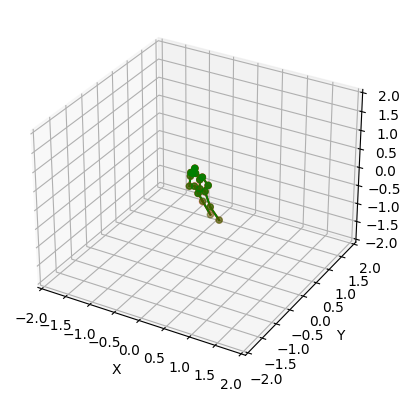

In [10]:
type(data_3d)

numpy.ndarray

In [ ]:
import torch
from tensor_ergonomics import RULAXXX

def run_pose_optimization(original_pose, num_steps=300):
    """
    Optimize the pose using the RULA score.
    
    Parameters:
    - original_pose: A tensor of shape (17, 3)
    
    Returns:
    - Optimized pose.
    """

    # Initialize the pose to be optimized
    pose = original_pose.clone().detach().requires_grad_(True)

    # Define an optimizer. Here, we use the Adam optimizer.
    optimizer = torch.optim.Adam([pose], lr=0.01)

    for step in range(num_steps):
        optimizer.zero_grad()

        # Compute the RULA score for the current pose            
        rula_eval = RULAXXX(original_pose)
        print(rula_eval)
        rula_score = rula_eval.compute_scores()
        
        # We want to minimize the RULA score, so we negate it for optimization
        loss = -rula_score

        # Backpropagate the loss
        loss.backward()

        # Update the pose
        optimizer.step()

        # Print the RULA score every 50 steps
        if step % 50 == 0:
            print(f"Step {step}: RULA Score: {rula_score.item()}")

    return pose


# Optimize the pose
original_pose = data_3d
original_pose_tensor = torch.tensor(original_pose, dtype=torch.float32, requires_grad=True)
print(original_pose_tensor.shape) #torch.Size([17, 3])
optimized_pose = run_pose_optimization(original_pose_tensor)
